In [1]:
import os
import random
import numpy as np
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader
from src.train import train, plot_metrics
from models.eegnet import EEGNet
from src.dataset.MI_dataset_single_subject import MI_Dataset
from config.over60 import cfg


from utils.eval import accuracy
from utils.model import print_parameters, print_weights_statistics

%load_ext autoreload
%autoreload 2


In [2]:
device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
type(cfg['data']['subjects'])

list

In [4]:
train_dataset = MI_Dataset.get_concat_dataset(cfg, split='train', return_subject_id = False, device=device, verbose=False)
train_dataloader = DataLoader(train_dataset, batch_size=cfg['train']['batch_size'], shuffle=True)
print(f"Train dataset: {len(train_dataset)} samples")

test_dataset = MI_Dataset.get_concat_dataset(cfg, split='test', return_subject_id =False, device=device, verbose=False)
test_dataloader = DataLoader(test_dataset, batch_size=cfg['train']['batch_size'], shuffle=False)
print(f"Test dataset: {len(test_dataset)} samples")

Creating dataset...
Saving dataset to cache\all_subjects_1-2-3-7-8\train_dataset.pkl...
Train dataset: 1200 samples
Creating dataset...
Saving dataset to cache\all_subjects_1-2-3-7-8\test_dataset.pkl...
Test dataset: 240 samples


In [5]:
model = EEGNet(num_classes=4, channels=22, samples=401, dropout_rate=0.5, kernel_length=64,  depth_multiplier=2, num_filters2=32, norm_rate=0.25)
model.to(device)
print_parameters(model)

conv1.weight.... --> 1024
bn1.weight...... --> 16
bn1.bias........ --> 16
dw_conv1.weight. --> 704
bn2.weight...... --> 32
bn2.bias........ --> 32
sep_conv1.weight --> 512
conv2.weight.... --> 1024
bn3.weight...... --> 32
bn3.bias........ --> 32
dense.weight.... --> 1536
dense.bias...... --> 4

Total Parameter Count: --> 4964


In [6]:
loss, val_loss, train_acc, val_acc = train(model, train_dataloader, test_dataloader, cfg['train'])

Epoch 10/100, Loss: 1.1073947988058392, Val Loss: 1.1592449247837067, Train accuracy: 54.00%, Test accuracy: 50.00%
Epoch 20/100, Loss: 0.925149635264748, Val Loss: 1.094180017709732, Train accuracy: 61.58%, Test accuracy: 51.25%
Epoch 30/100, Loss: 0.8267062682854501, Val Loss: 1.1527598649263382, Train accuracy: 66.00%, Test accuracy: 54.17%
Epoch 40/100, Loss: 0.8187257396547418, Val Loss: 1.1467552781105042, Train accuracy: 66.25%, Test accuracy: 54.17%
Epoch 50/100, Loss: 0.7859644889831543, Val Loss: 1.16440150141716, Train accuracy: 67.58%, Test accuracy: 55.42%
Epoch 60/100, Loss: 0.7666424481492293, Val Loss: 1.1474266052246094, Train accuracy: 68.33%, Test accuracy: 55.83%
Epoch 70/100, Loss: 0.7377556656536303, Val Loss: 1.1933679580688477, Train accuracy: 68.75%, Test accuracy: 55.42%
Epoch 80/100, Loss: 0.73968442803935, Val Loss: 1.1671270281076431, Train accuracy: 70.75%, Test accuracy: 56.25%
Epoch 90/100, Loss: 0.7251395520411039, Val Loss: 1.1891256421804428, Train ac

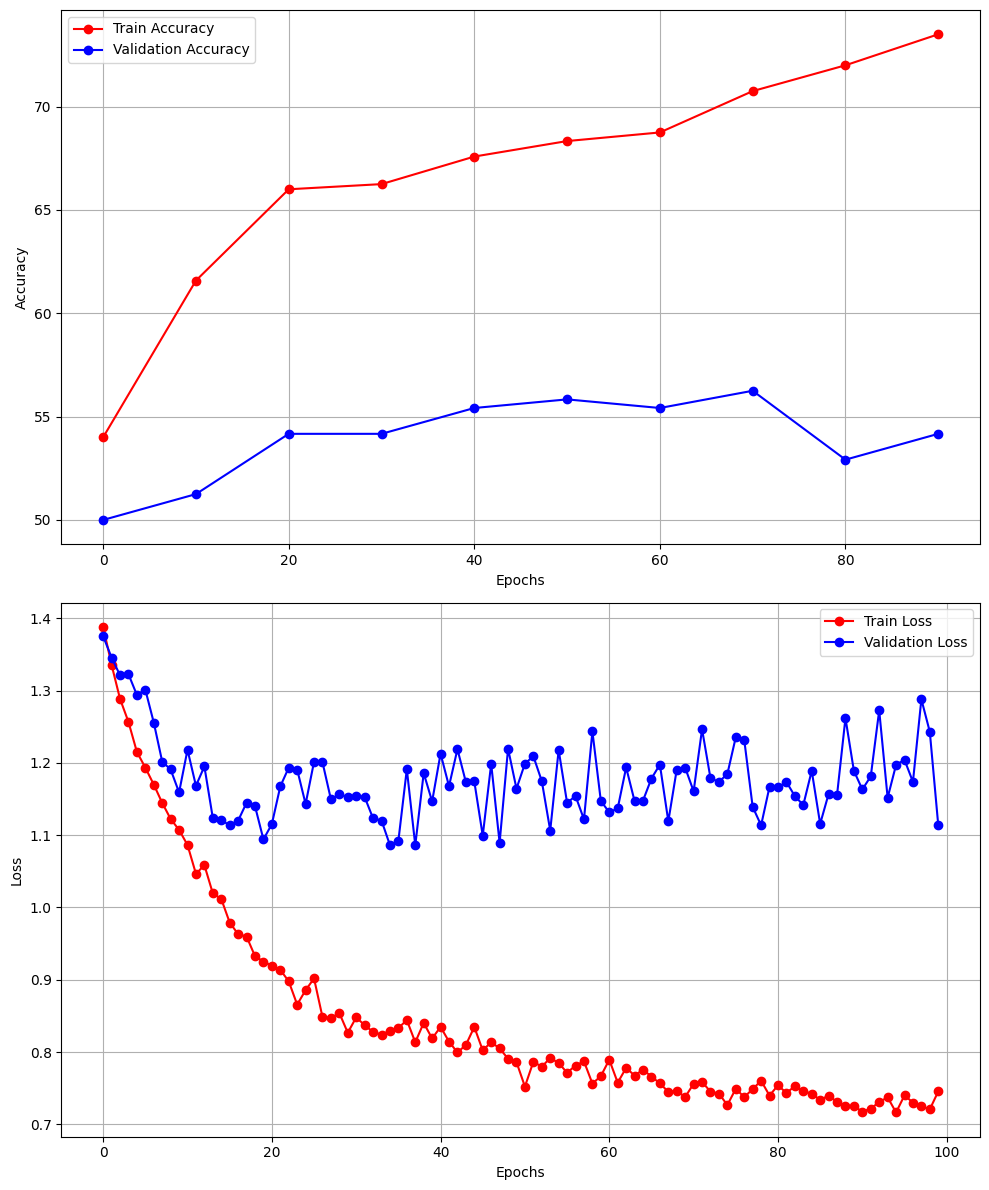

In [7]:
plot_metrics(loss, val_loss, train_acc, val_acc)